# Fiducially testing CLASS and scipy.optimize functions:

Because CLASS makes use of only 2 params in HMCode (versus the three baryon params for CAMB), the parameter space is smaller by a whole dimension. That being said, I want to determine whether or not scipy.optimize functions can fit the data given to it. The results of this test suggested this was the case.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from classy import Class



%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

### Creating "fake" observational data 

In [5]:
data = Class() 
fiducial_eta = 1.5
fiducial_c = 4

data.set({'output':'mPk',
          'non_linear':'hmcode',
          'eta_0':fiducial_eta,
          'c_min':fiducial_c, 
          'P_k_max_h/Mpc':10, 
          'lensing':'no', 
          'z_pk':0, 
          })

data.compute() 

In [6]:
ks_data = np.logspace(-5, 1, 1000) # k in h/Mpc

Pks_data = [] 
h = data.h() # get reduced Hubble for conversions to 1/Mpc
for k in ks_data:
    Pk = data.pk(k*h, 0)*h**3 # function .pk(k,z)
    Pks_data.append(Pk) 

Pks_data = np.array(Pks_data) # P(k) in (Mpc/h)**3

### Using default feedback params

In [7]:
default = Class() 

default.set({'output':'mPk',
          'non_linear':'hmcode', 
          'feedback model':'owls_agn', 
          'P_k_max_h/Mpc':10, 
          'lensing':'no', 
          'z_pk':0,
          })

default.compute()

In [8]:
ks_default = np.logspace(-5, 1, 1000) # k in h/Mpc

Pks_default = [] 
h = default.h() # get reduced Hubble for conversions to 1/Mpc
for k in ks_default:
    Pk = default.pk(k*h, 0)*h**3 # function .pk(k,z)
    Pks_default.append(Pk) 

Pks_default = np.array(Pks_default) # P(k) in (Mpc/h)**3

### Quick Plot

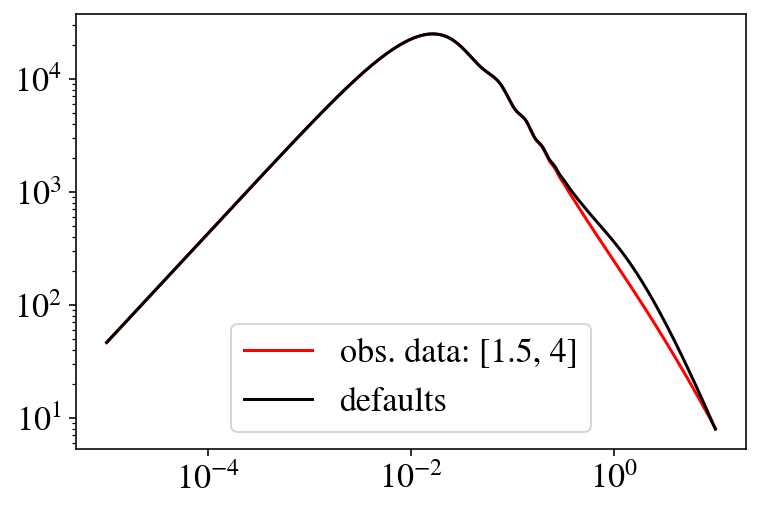

In [9]:
plt.figure()
plt.loglog(ks_data, Pks_data, 'r', label="obs. data: [1.5, 4]")
plt.loglog(ks_default, Pks_default, 'k', label="defaults")
plt.legend()
plt.show()

## scipy.optimize.curve_fit()

In [10]:
def class_model_cf(x_data, eta, c):
    model = Class()
    model.set({'output':'mPk',
          'non_linear':'hmcode',
          'eta_0':eta,
          'c_min':c, 
          'P_k_max_h/Mpc':10, 
          'lensing':'no', 
          'z_pk':0, 
          })
    model.compute()
    
    ks_model = x_data
    Pks_model = [] 
    h = model.h() 
    for k in ks_model:
        Pk = model.pk(k*h, 0)*h**3
        Pks_model.append(Pk) 
    Pks_model = np.array(Pks_model)
    
    return Pks_model

In [11]:
guesses = np.array([0.5, 2.0])
popt_cf, pcov_cf = scipy.optimize.curve_fit(class_model_cf, ks_data, Pks_data, guesses) 
popt_cf

array([1.5, 4. ])

## scipy.optimize.least_squares()

In [12]:
def class_model_ls(baryons):
    model = Class()
    model.set({'output':'mPk',
          'non_linear':'hmcode',
          'eta_0':baryons[0],
          'c_min':baryons[1], 
          'P_k_max_h/Mpc':10, 
          'lensing':'no', 
          'z_pk':0, 
          })
    model.compute()
    
    ks_model = np.logspace(-5, 1, 1000)
    Pks_model = [] 
    h = model.h() 
    for k in ks_model:
        Pk = model.pk(k*h, 0)*h**3
        Pks_model.append(Pk) 
    Pks_model = np.array(Pks_model)
    
    return ks_model, Pks_model

In [13]:
def residuals(baryons, y_data, x_data):
    return y_data - class_model_ls(baryons)[1]

In [14]:
guesses = np.array([0.5, 2])

ls = scipy.optimize.least_squares(residuals, guesses, args=(Pks_data, ks_data))
ls.x

array([1.5, 4. ])

## Plotting and Comparing Results

<Figure size 432x288 with 0 Axes>

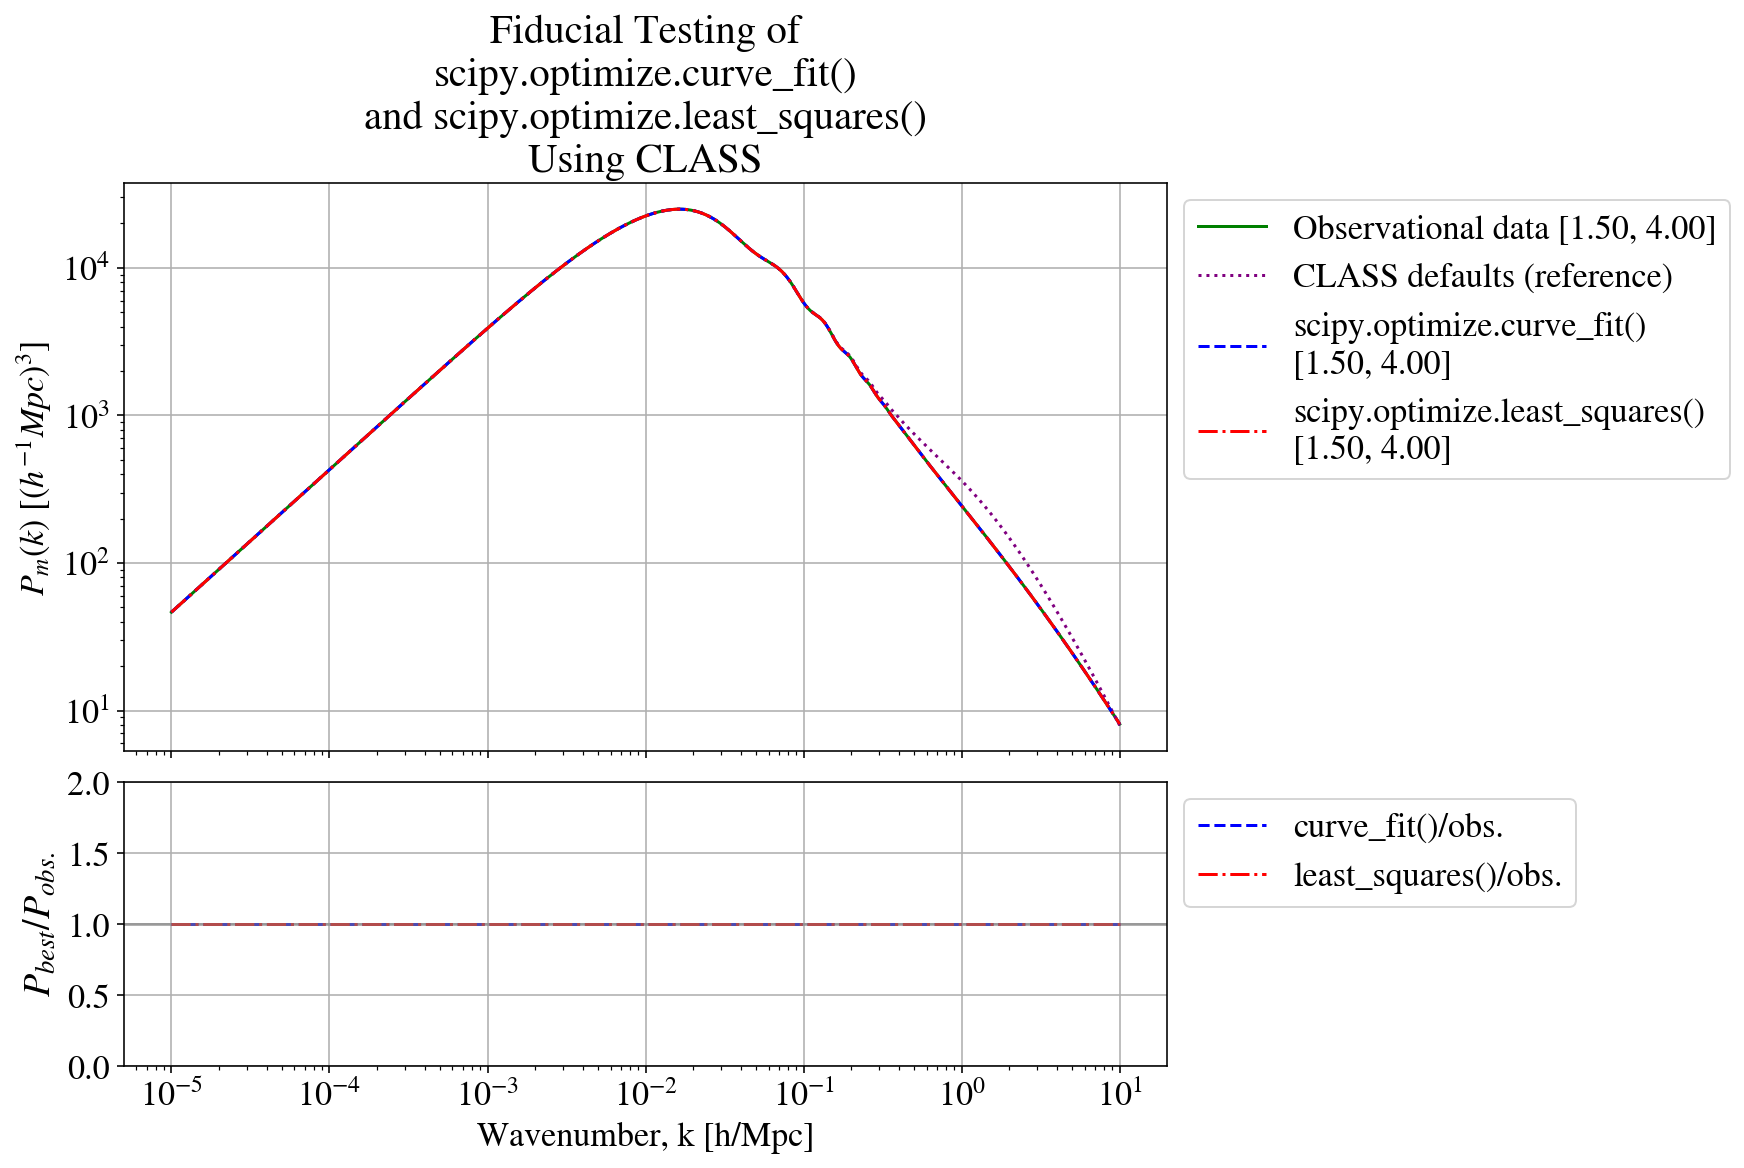

In [15]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, 
                               figsize=(12,8), 
                               constrained_layout=True, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[2, 1]})

ax0.loglog(ks_data, Pks_data, 'green', label='Observational data [{0:.2f}, {1:.2f}]'.format(fiducial_eta, fiducial_c))
ax0.loglog(ks_default, Pks_default, 'purple', linestyle=':', label='CLASS defaults (reference)')
ax0.loglog(class_model_ls(popt_cf)[0], class_model_ls(popt_cf)[1], 'b', linestyle='--', label='scipy.optimize.curve_fit()\n[{0:.2f}, {1:.2f}]'.format(*popt_cf))
ax0.loglog(class_model_ls(ls.x)[0], class_model_ls(ls.x)[1], 'red', linestyle='-.', label='scipy.optimize.least_squares()\n[{0:.2f}, {1:.2f}]'.format(*ls.x))

ax0.grid()
ax0.set_title('Fiducial Testing of\nscipy.optimize.curve_fit()\nand scipy.optimize.least_squares()\nUsing CLASS')
ax0.set_ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
ax0.legend(bbox_to_anchor = (1, 1), loc='upper left')

ax1.semilogx(class_model_ls(popt_cf)[0], class_model_ls(popt_cf)[1]/Pks_data, color='blue', linestyle='--', label='curve_fit()/obs.')
ax1.semilogx(class_model_ls(ls.x)[0], class_model_ls(ls.x)[1]/Pks_data, color='red', linestyle='-.', label='least_squares()/obs.')
ax1.legend(bbox_to_anchor = (1, 1), loc='upper left')
ax1.axhline(1, color='grey', alpha=0.6)
ax1.set_ylabel('$P_{best}/P_{obs.}$', fontsize=19)
ax1.set_xlabel('Wavenumber, k [h/Mpc]')
ax1.set_ylim(0, 2)
ax1.grid()
plt.show()